In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import copy

font_path = "C:/Windows/Fonts/MALGUN.TTF"
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rc('xtick', labelsize=10)
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 셋 불러오기

train = pd.read_csv("../../../data/dacon_parking_demand_dataset/train.csv")
test = pd.read_csv("../../../data/dacon_parking_demand_dataset/test.csv")
sub = pd.read_csv("../../../data/dacon_parking_demand_dataset/sample_submission.csv")
age = pd.read_csv("../../../data/dacon_parking_demand_dataset/age_gender_info.csv")

In [3]:
train.shape, test.shape

((2952, 15), (1022, 14))

### 데이터 셋의 오류 처리

In [4]:
# 오류1번 트레인 셋 처리
# 총세대수와 전용면적별 세대수 합이 다른 단지코드의 값을 -> 전용면적별세대수의 합으로 수정하기

def house_number_correction(df):
    error_1_group = df.groupby("단지코드")[["총세대수"]]
    total_number_house_hold = error_1_group.mean()

    error_2_group = df.groupby("단지코드")["전용면적별세대수"]
    sum_house_hold = error_2_group.sum()

    check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
    different_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

    total_house_index = different_df.index
    total_house_number = []
    for v in different_df.values:
        total_house_number.append(v[1])
    
    for code, value in zip(total_house_index, total_house_number):
         df.loc[df["단지코드"] == code, "총세대수"] = value
    
    return df

train = house_number_correction(train)
test = house_number_correction(test)

In [5]:
# 데이터 셋 1번 오류 처리 확인

error_1_group = train.groupby("단지코드")[["총세대수"]]
total_number_house_hold = error_1_group.mean()

error_2_group = train.groupby("단지코드")["전용면적별세대수"]
sum_house_hold = error_2_group.sum()

check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
check_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

print(check_df.shape)
check_df

(0, 2)


,총세대수,전용면적별세대수
단지코드,,


In [6]:
error_1_group = test.groupby("단지코드")[["총세대수"]]
total_number_house_hold = error_1_group.mean()

error_2_group = test.groupby("단지코드")["전용면적별세대수"]
sum_house_hold = error_2_group.sum()

check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
check_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

check_df.shape

(0, 2)

In [7]:
# 오류2번 3번 처리하기

train[(train["단지코드"] == "C2675") | (train["단지코드"] == "C2335") | (train["단지코드"] == "C1327")]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수


In [8]:
test[(test["단지코드"] == "C2675") | (test["단지코드"] == "C2335") | (test["단지코드"] == "C1327")].head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
579,C2675,512,아파트,경기도,국민임대,36.65,130,9.0,A,18476000,154790,0.0,3.0,1016.0
580,C2675,512,아파트,경기도,국민임대,46.90,44,9.0,A,34082000,232200,0.0,3.0,1016.0
581,C2675,512,아파트,경기도,국민임대,46.90,80,9.0,A,34082000,232200,0.0,3.0,1016.0


In [9]:
# 테스트 데이터 셋에서 세개의 코드 데이터를 없애기 (2, 3번 3개 코드 제거)

error_index = test[(test["단지코드"] == "C2675") | (test["단지코드"] == "C2335") | (test["단지코드"] == "C1327")].index
test = test.drop(index=error_index, axis=0)

In [10]:
# 에러2번의 5개 단지코드 트레인 셋 제거

train_set_error_index = train[(train["단지코드"] =="C2085") | (train["단지코드"] =="C1397") | (train["단지코드"] =="C2431") | (train["단지코드"] =="C1649") | (train["단지코드"] =="C1036")].index
train = train.drop(index=train_set_error_index, axis=0)

In [11]:
# 에러3번의 트레인 셋 7개 단지 코드 제거

train_set_error_index = train[(train["단지코드"] =="C1095") | (train["단지코드"] =="C2051") | (train["단지코드"] =="C1218") | (train["단지코드"] =="C1894") | (train["단지코드"] =="C2483") | (train["단지코드"] =="C1502") | (train["단지코드"] =="C1988")].index
train = train.drop(index=train_set_error_index, axis=0)

### 데이터셋 전처리

In [12]:
# 자격 유형 피처 전처리

test.loc[196, "자격유형"] = "A"
test.loc[258, "자격유형"] = "C"
test.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     38
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

In [13]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    207
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [14]:
# 임대보증금 피처 전처리
# 임대보증금이 0인 행의 데이터를 -> 트레인 셋의 중앙값으로 치환

train_df = train.copy(deep=True)
test_df = test.copy(deep=True)

train_df["임대보증금"] = train_df["임대보증금"].fillna(0)
train_df.loc[train_df["임대보증금"] == "-", "임대보증금"] = 0
train_df["임대보증금"] = train_df["임대보증금"].astype(int)
train_df.loc[train_df["임대보증금"] == 0, "임대보증금"] = train_df["임대보증금"].median()

test_df["임대보증금"] = test_df["임대보증금"].fillna(0)
test_df.loc[test_df["임대보증금"] == "-", "임대보증금"] = 0
test_df["임대보증금"] = test_df["임대보증금"].astype(int)
test_df.loc[test_df["임대보증금"] == 0, "임대보증금"] = train_df["임대보증금"].median()

In [15]:
# 레이블 인코딩 -> 원핫 인코딩으로 전환

qualification_type_feature = pd.get_dummies(train_df["자격유형"])
train_df = pd.concat([train_df, qualification_type_feature], axis=1)

qualification_type_feature = pd.get_dummies(test_df["자격유형"])
test_df = pd.concat([test_df, qualification_type_feature], axis=1)

test_df["B"] = 0
test_df["F"] = 0
test_df["O"] = 0

In [16]:
train_df.shape, test_df.shape

((2869, 30), (1008, 29))

In [17]:
# 실거주 세대수 피처 생성

train_df["실거주세대수"] = train_df["총세대수"] - train_df["공가수"].astype(int)
test_df["실거주세대수"] = test_df["총세대수"] - test_df["공가수"].astype(int)

In [18]:
# 세대수 별 주차면수 피처 생성

train_df["세대수비율주차면수"] = (train_df["전용면적별세대수"] / train_df["실거주세대수"]) * train_df["단지내주차면수"]
test_df["세대수비율주차면수"] = (test_df["전용면적별세대수"] / test_df["실거주세대수"]) * test_df["단지내주차면수"]

In [19]:
# 버스정류장 피처 전처리
# 최빈값인 2로 채우기

train_df["도보 10분거리 내 버스정류장 수"] = train_df["도보 10분거리 내 버스정류장 수"].fillna(2)
test_df["도보 10분거리 내 버스정류장 수"] = test_df["도보 10분거리 내 버스정류장 수"].fillna(2)

In [20]:
# 전철역 피처 전처리
# Null 값 0으로 채우기

train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)
test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)

<AxesSubplot:>

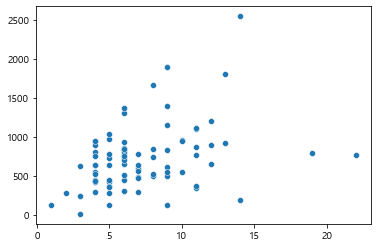

In [21]:
# 지역 피처의 선형성 시각화 ex) 경기도

area_group = train_df.groupby("지역")["등록차량수"]

values = area_group.get_group("경기도").value_counts().index
counts = area_group.get_group("경기도").value_counts().values

sns.scatterplot(x=counts, y=values)

In [22]:
# 지역 피처 원핫 인코딩

area_df = pd.get_dummies(train_df["지역"])
area_df = area_df.drop("서울특별시", axis=1)
train_df = pd.concat([train_df, area_df], axis=1)

area_df = pd.get_dummies(test_df["지역"])
test_df = pd.concat([test_df, area_df], axis=1)

In [23]:
# 임대건물 구분 피처 전처리 (아파트, 상가 원핫 인코딩)

train_df = pd.concat([train_df, pd.get_dummies(train_df["임대건물구분"])], axis=1)
train_df.drop("임대건물구분", axis=1, inplace=True)

test_df = pd.concat([test_df, pd.get_dummies(test_df["임대건물구분"])], axis=1)
test_df.drop("임대건물구분", axis=1, inplace=True)

In [24]:
# 전용 면적 피처를 5의 배수로 전처리

train_df["전용면적"] = train_df["전용면적"] // 5*5
test_df["전용면적"] = test_df["전용면적"] // 5*5

In [25]:
# 세대수 규모 당 총 전용 면적 피처 생성

train_df["세대수 규모 당 총 전용면적"] = train_df["전용면적"] * train_df["전용면적별세대수"]
test_df["세대수 규모 당 총 전용면적"] = test_df["전용면적"] * test_df["전용면적별세대수"]

In [26]:
# 단지별 총 전용 면적 피처 생성

train_df["단지별 총 전용면적"] = train_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)
test_df["단지별 총 전용면적"] = test_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)

In [27]:
# 전용면적 당 차량등록수 피처 생성

train_df["전용면적 당 차량등록수"] = (train_df["세대수 규모 당 총 전용면적"] / train_df["단지별 총 전용면적"]) * train_df["등록차량수"]

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 8 to 2951
Data columns (total 51 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2869 non-null   object 
 1   총세대수                          2869 non-null   int64  
 2   지역                            2869 non-null   object 
 3   공급유형                          2869 non-null   object 
 4   전용면적                          2869 non-null   float64
 5   전용면적별세대수                      2869 non-null   int64  
 6   공가수                           2869 non-null   float64
 7   자격유형                          2869 non-null   object 
 8   임대보증금                         2869 non-null   int32  
 9   임대료                           2300 non-null   object 
 10  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2869 non-null   float64
 11  도보 10분거리 내 버스정류장 수            2869 non-null   float64
 12  단지내주차면수                       2869 non-null   float64
 13  등록차

### 이변량 분석
* 독립변수 & 종속변수간의 선형성 시각화
* 이상치 (Outlier) 제거

<AxesSubplot:xlabel='전용면적별세대수', ylabel='전용면적 당 차량등록수'>

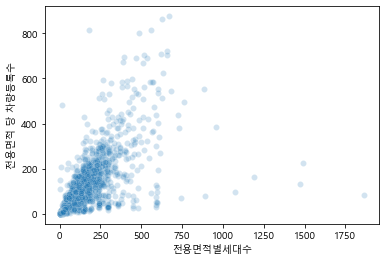

In [29]:
sns.scatterplot(data=train_df, x="전용면적별세대수", y="전용면적 당 차량등록수", alpha=0.2)

In [30]:
# 이상치 처리 503, 1871, 1951, 1977, 2023

outlier_index = train_df[train_df["전용면적별세대수"] >= 1000].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [31]:
outlier_index = train_df[(train_df["전용면적별세대수"] <= 30) & (train_df["전용면적 당 차량등록수"] >=400)].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [32]:
# 301 아웃라이어 제거

train_df[(train_df["전용면적별세대수"] > 150) & (train_df["전용면적 당 차량등록수"] > 750)]

train_df = train_df.drop(index=301, axis=0)

<AxesSubplot:xlabel='전용면적별세대수', ylabel='Count'>

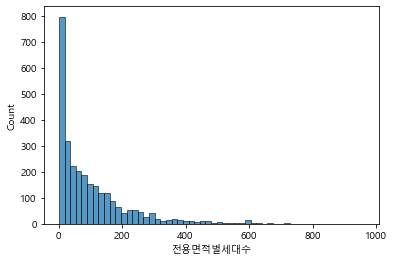

In [33]:
sns.histplot(train_df["전용면적별세대수"])

<AxesSubplot:xlabel='세대수 규모 당 총 전용면적', ylabel='전용면적 당 차량등록수'>

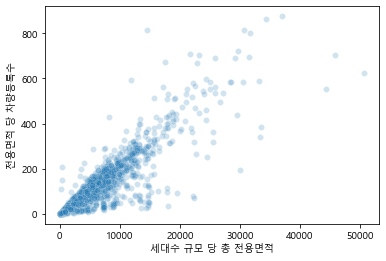

In [34]:
sns.scatterplot(data=train_df, x="세대수 규모 당 총 전용면적", y="전용면적 당 차량등록수", alpha=0.2)

In [35]:
# 1974, 2141, 2532

outlier_index = train_df[train_df["세대수 규모 당 총 전용면적"] > 40000].index

train_df = train_df.drop(index=outlier_index, axis=0)

<AxesSubplot:xlabel='세대수 규모 당 총 전용면적', ylabel='Count'>

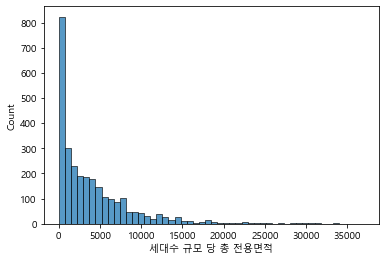

In [36]:
sns.histplot(train_df["세대수 규모 당 총 전용면적"])

<AxesSubplot:xlabel='실거주세대수', ylabel='전용면적 당 차량등록수'>

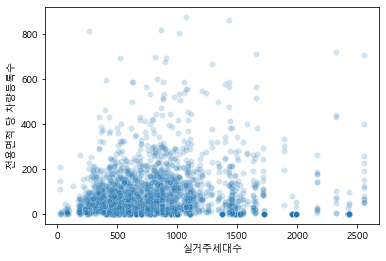

In [37]:
sns.scatterplot(data=train_df, x="실거주세대수", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='실거주세대수', ylabel='Count'>

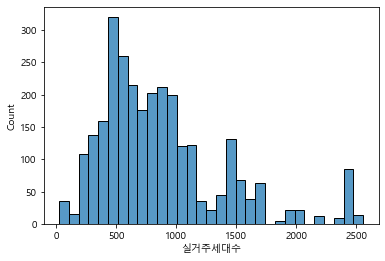

In [38]:
sns.histplot(train_df["실거주세대수"])

<AxesSubplot:xlabel='단지별 총 전용면적', ylabel='전용면적 당 차량등록수'>

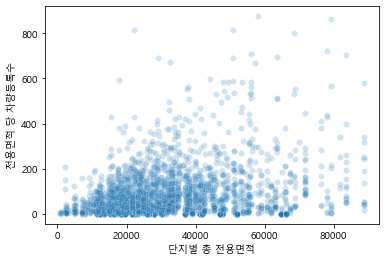

In [39]:
sns.scatterplot(data=train_df, x="단지별 총 전용면적", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='단지별 총 전용면적', ylabel='Count'>

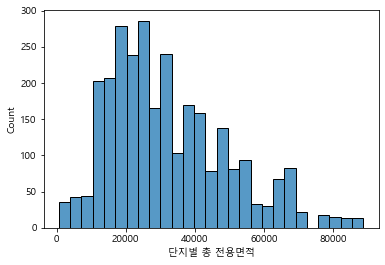

In [40]:
sns.histplot(train_df["단지별 총 전용면적"])

<AxesSubplot:xlabel='임대보증금', ylabel='전용면적 당 차량등록수'>

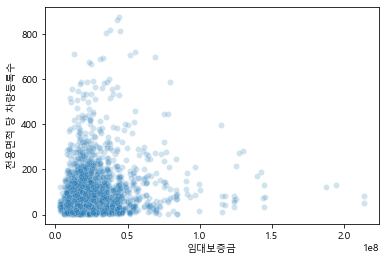

In [41]:
sns.scatterplot(data=train_df, x="임대보증금", y="전용면적 당 차량등록수", alpha=0.2)

In [42]:
# 임대보증금 아웃라이어 2111, 2812, 2813, 2814 제거

outlier_index = train_df[train_df["임대보증금"] >= 187694000].index
train_df = train_df.drop(index=outlier_index, axis=0)

<AxesSubplot:xlabel='도보 10분거리 내 버스정류장 수', ylabel='전용면적 당 차량등록수'>

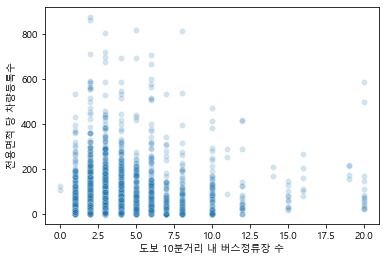

In [43]:
sns.scatterplot(data=train_df, x="도보 10분거리 내 버스정류장 수", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='도보 10분거리 내 버스정류장 수', ylabel='Count'>

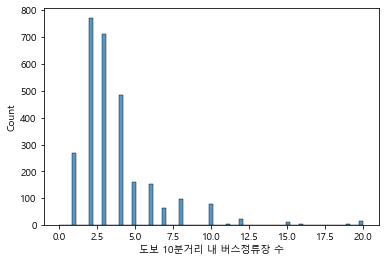

In [44]:
sns.histplot(train_df["도보 10분거리 내 버스정류장 수"])

<AxesSubplot:xlabel='도보 10분거리 내 지하철역 수(환승노선 수 반영)', ylabel='전용면적 당 차량등록수'>

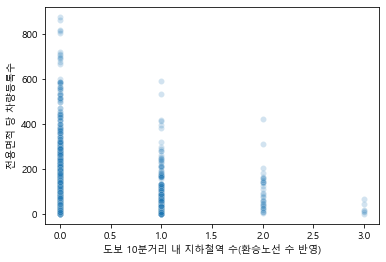

In [45]:
sns.scatterplot(data=train_df, x="도보 10분거리 내 지하철역 수(환승노선 수 반영)", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='도보 10분거리 내 지하철역 수(환승노선 수 반영)', ylabel='Count'>

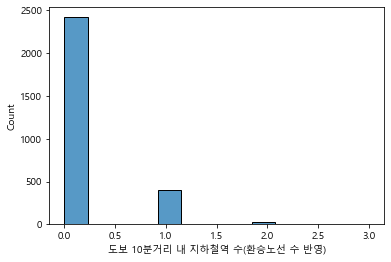

In [46]:
sns.histplot(train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"])

<AxesSubplot:xlabel='상가', ylabel='전용면적 당 차량등록수'>

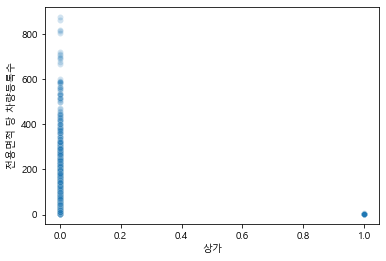

In [47]:
sns.scatterplot(data=train_df, x="상가", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

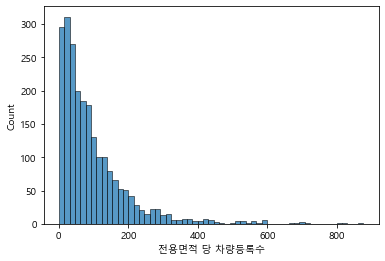

In [48]:
sns.histplot(train_df[train_df["상가"] == 0]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

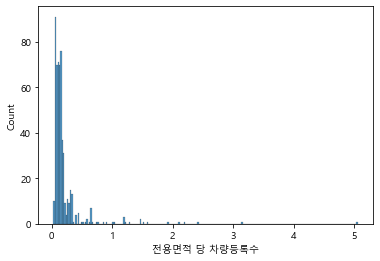

In [49]:
sns.histplot(train_df[train_df["상가"] == 1]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

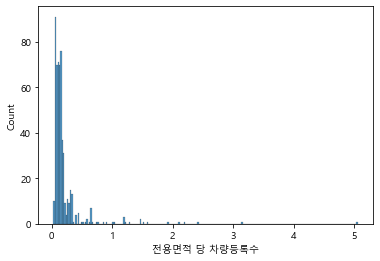

In [50]:
sns.histplot(train_df[train_df["아파트"] == 0]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

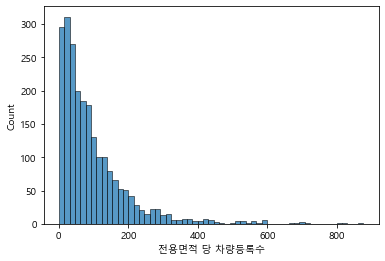

In [51]:
sns.histplot(train_df[train_df["아파트"] == 1]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

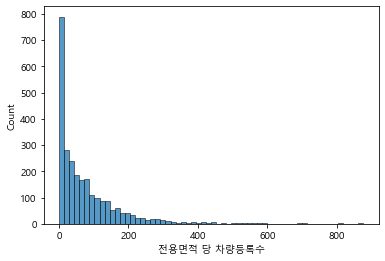

In [52]:
sns.histplot(train_df[train_df["강원도"] == 0]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='자격유형', ylabel='전용면적 당 차량등록수'>

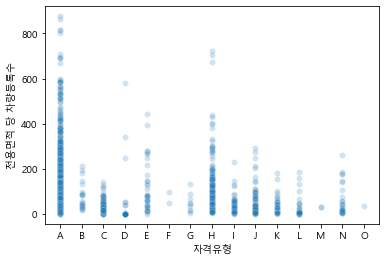

In [53]:
sns.scatterplot(data=train_df, x="자격유형", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='지역', ylabel='전용면적 당 차량등록수'>

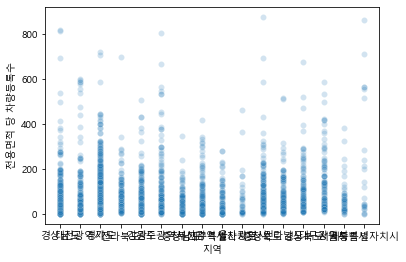

In [54]:
sns.scatterplot(data=train_df, x="지역", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='세대수비율주차면수', ylabel='전용면적 당 차량등록수'>

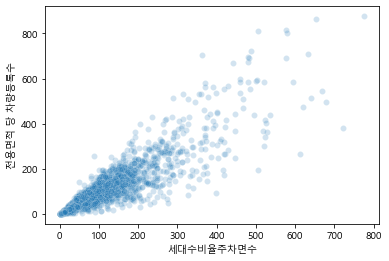

In [55]:
sns.scatterplot(data=train_df, x="세대수비율주차면수", y="전용면적 당 차량등록수", alpha=0.2)

In [56]:
# 세대수비율주차면수 아웃라이어 제거 314

outlier_index = train_df[(train_df["세대수비율주차면수"] >= 700) & (train_df["전용면적 당 차량등록수"] < 400)].index
train_df = train_df.drop(index=outlier_index, axis=0)

<AxesSubplot:>

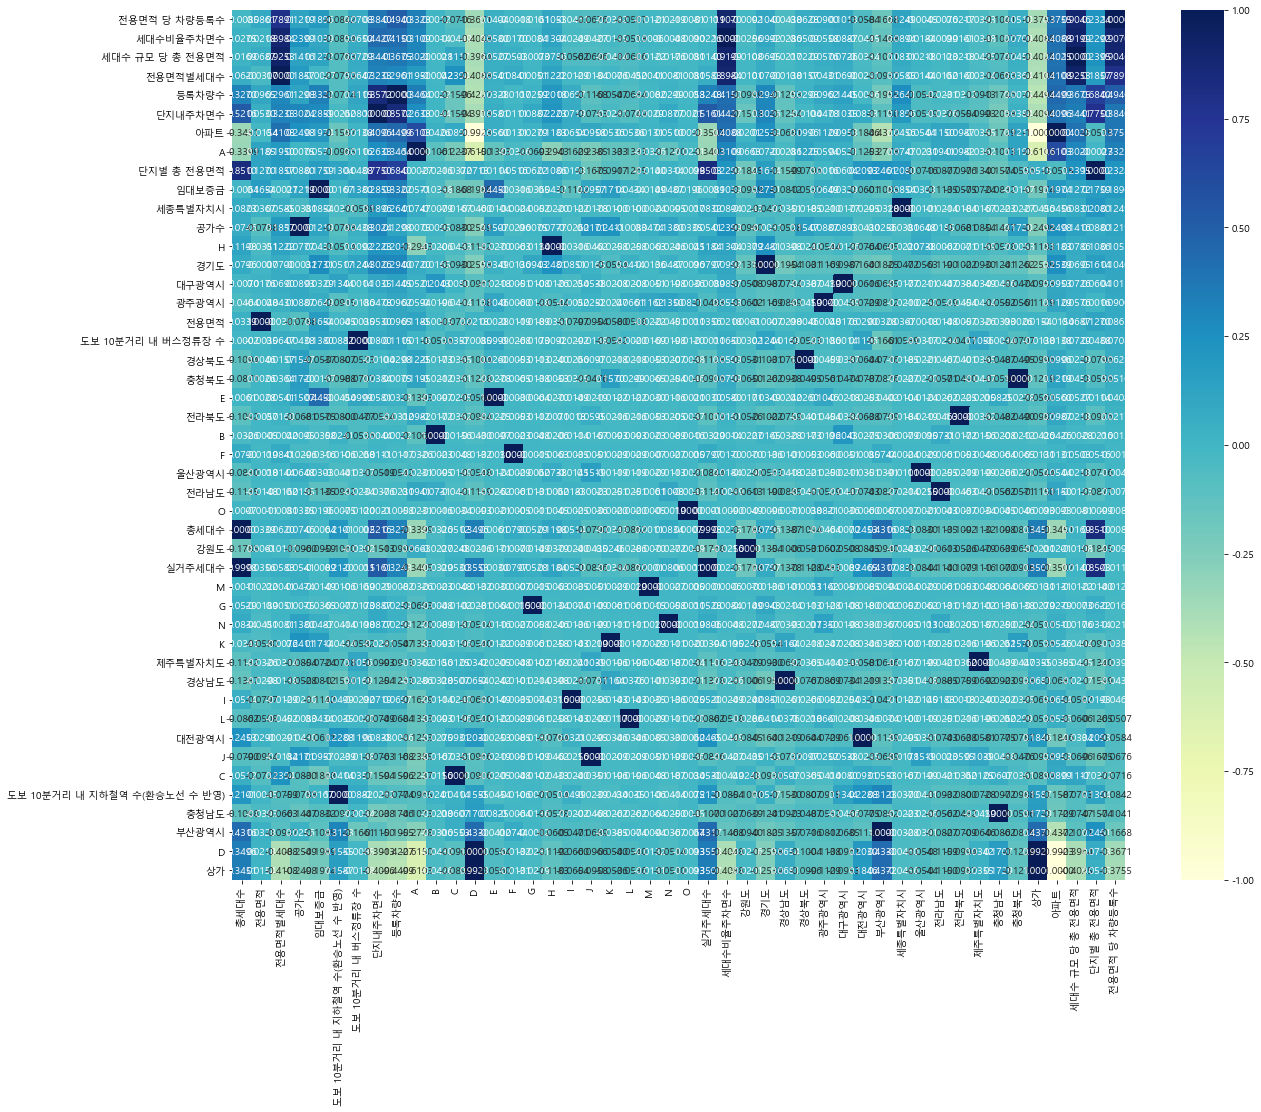

In [57]:
correlation_df = train_df.corr().sort_values(by="전용면적 당 차량등록수", ascending=False)

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_df, annot=True, fmt=".4f", cmap='YlGnBu')

In [58]:
# X_train & X_test 셋 선택

# 다중공선성 가능성 피처: 
# "상가", "등록차량수", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료"
# "전용면적 당 차량등록수", "총세대수"

X_train_df_sel = train_df.drop(["단지코드", "상가", "등록차량수", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
 "전용면적 당 차량등록수", "총세대수"], axis=1)

X_test_df_sel = test_df.drop(["단지코드", "상가", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
 "총세대수"], axis=1)

y_train_df = train_df["전용면적 당 차량등록수"]

In [59]:
X_train_df_sel.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적'],
      dtype='object')

In [60]:
# 테스트 셋의 피처 순서 정렬

column_names = ['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수',
       '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시',
       '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도', '아파트',
       '세대수 규모 당 총 전용면적']

X_test_df_sel = X_test_df_sel.reindex(columns=column_names)
X_test_df_sel.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적'],
      dtype='object')

In [61]:
X_train_df_sel

,전용면적별세대수,공가수,임대보증금,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,A,B,C,D,E,...,부산광역시,세종특별자치시,울산광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도,아파트,세대수 규모 당 총 전용면적
8,276,17.0,9216000,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,8280.0
9,60,17.0,12672000,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2100.0
10,20,17.0,12672000,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,700.0
11,38,17.0,18433000,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1710.0
12,19,17.0,18433000,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,855.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,19,7.0,11346000,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,855.0
2948,34,7.0,14005000,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1700.0
2949,34,7.0,14005000,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1700.0
2950,114,7.0,14005000,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5700.0


In [62]:
# 데이터 셋에 로그 정규화를 적용하여, 데이터 셋의 스케일 조정 및 정규분포화

X_train_df_log = X_train_df_sel.apply(lambda x: np.log1p(x))
X_test_df_log = X_test_df_sel.apply(lambda x: np.log1p(x))
y_train_df_log = y_train_df.apply(lambda x: np.log1p(x))

### Linear Regression Model Hyper parameter tuning with GridSearchCV

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [64]:
# 선형회귀 모델 최적의 alpha 값 탐색

params = {"alpha": [0.01, 0.1, 0.3, 0.5, 1, 3, 5, 10, 20]}

elastic_params = {"alpha": [0.01, 0.1, 0.3, 0.5, 1, 3, 5, 10, 20],
                 "l1_ratio": [0.1, 0.3, 0.5, 0.7, 1]}


ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()

grid_ridge = GridSearchCV(ridge, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
grid_lasso = GridSearchCV(lasso, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
grid_elastic = GridSearchCV(elastic, param_grid=elastic_params, cv=5, scoring="neg_mean_absolute_error")

grid_ridge.fit(X_train_df_log, y_train_df_log)
grid_lasso.fit(X_train_df_log, y_train_df_log)
grid_elastic.fit(X_train_df_log, y_train_df_log)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 0.3, 0.5, 1, 3, 5, 10, 20],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 1]},
             scoring='neg_mean_absolute_error')

In [65]:
grid_ridge.best_params_

{'alpha': 20}

### 랜덤포레스트 모델 및 선형회귀 모델 평가

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

rf_reg = RandomForestRegressor(n_jobs=-1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25, random_state=42)

rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_test)

mean_absolute_error(np.expm1(y_test), np.expm1(pred))

14.168531222366084

In [71]:
# 랜덤포레스트 이상치처리 및 다중공선성피처제거한 데이터셋으로 학습

model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(X_train_df_log, y_train_df_log)
pred = model.predict(X_test_df_log)
pred = np.expm1(pred)

result = pd.DataFrame(data=pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub = sub.rename(columns={"code":"단지코드"})
sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})

sub_df

,code,num
0,C1072,778.229154
1,C1128,1365.825954
2,C1456,536.327324
3,C1840,447.038461
4,C1332,1207.737225
...,...,...
145,C2456,265.708933
146,C1266,350.390362
147,C2152,37.537601
148,C1267,369.275759


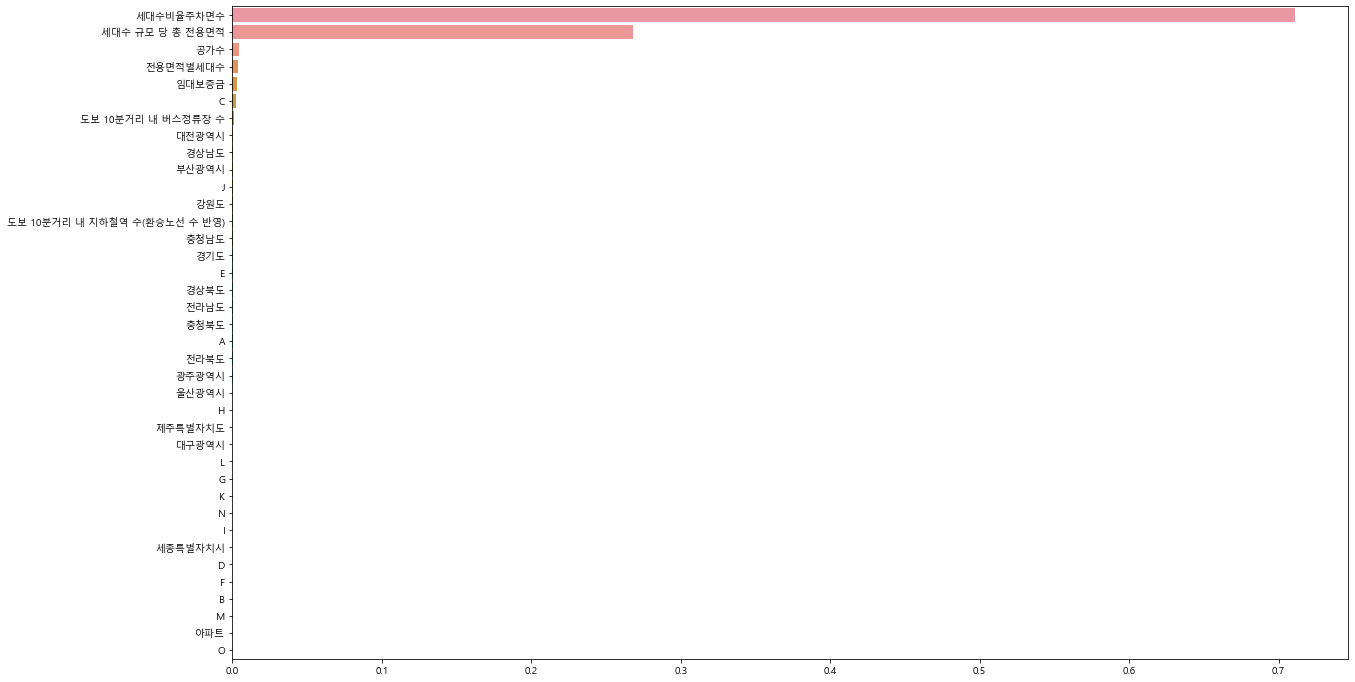

In [72]:
importance = model.feature_importances_
feature_importance = pd.Series(data=importance, index=X_train_df_sel.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()

In [73]:
# 라쏘 모델 예측 성능 평가

lasso_model = Lasso(alpha=0.01)
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25, random_state=42)

lasso_model.fit(X_train, y_train)
pred = lasso_model.predict(X_test)


mean_absolute_error(np.expm1(y_test), np.expm1(pred))

16.855143883683592

In [74]:
# 릿지 모델 예측 성능 평가

ridge_model = Ridge(alpha=20)
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25, random_state=42)

ridge_model.fit(X_train, y_train)
pred = ridge_model.predict(X_test)


mean_absolute_error(np.expm1(y_test), np.expm1(pred))

14.9751057183045

In [75]:
ridge_model.coef_

array([ 0.0385968 , -0.04447496,  0.22959158, -0.05203393, -0.00576769,
        0.22201644,  0.0502446 , -0.32056935,  0.2033559 , -0.14762457,
        0.        , -0.05040895,  0.17197051,  0.09143403, -0.04274724,
       -0.09641083,  0.02843547, -0.0152769 , -0.09095833, -0.00346079,
        0.56872142,  0.06038524, -0.04984245, -0.09390792,  0.1673845 ,
        0.11813948,  0.1231475 , -0.13910551, -0.12412773,  0.03061055,
       -0.03597305,  0.05673649,  0.02149139,  0.05335296, -0.01161314,
       -0.02453471, -0.13027706,  0.3503768 ])

In [76]:
X_train_df_log.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적'],
      dtype='object')

In [79]:
ridge_model = Ridge(alpha=20)

ridge_model.fit(X_train_df_log, y_train_df_log)
pred = ridge_model.predict(X_test_df_log)
pred = np.expm1(pred)

result = pd.DataFrame(data=pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub = sub.rename(columns={"code":"단지코드"})
sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})

sub_df

,code,num
0,C1072,705.130801
1,C1128,1200.416514
2,C1456,544.534600
3,C1840,494.427170
4,C1332,1143.017521
...,...,...
145,C2456,227.508412
146,C1266,422.175752
147,C2152,33.035849
148,C1267,320.266682


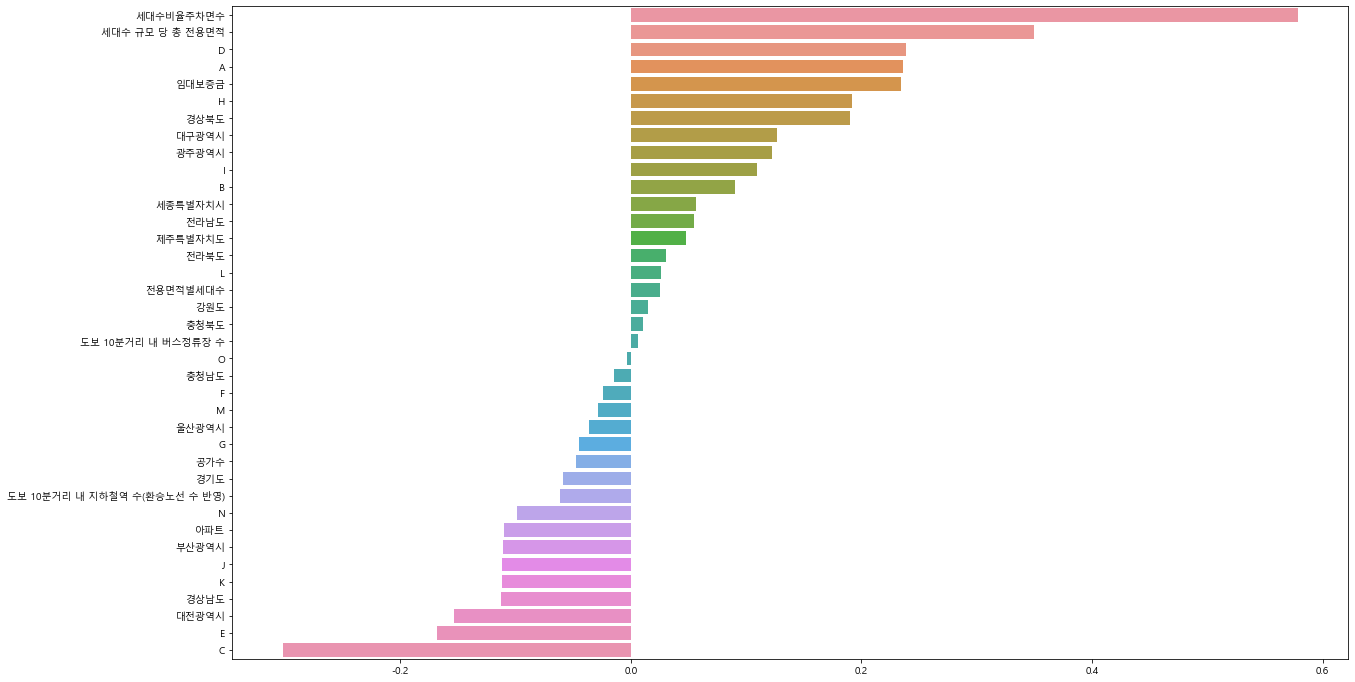

In [80]:
importance = ridge_model.coef_
feature_importance = pd.Series(data=importance, index=X_train_df_log.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()